In [1]:
import os
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap as lsc
import torch
import h5py

from deeplsd.utils.tensor import batch_to_device
from deeplsd.models.deeplsd_inference import DeepLSD
from deeplsd.geometry.viz_2d import plot_images, plot_lines

In [2]:
# Load an image
img = cv2.imread('../../images/1DJI0005.jpg')[:, :, ::-1]
#img = cv2.imread('../assets/images/example.jpg')[:, :, ::-1]
# img = cv2.resize(img, (640, 480))
# img = img[155:300, 270:445]

img = cv2.resize(img, (1280, 960))
img = img[310:600, 540:890]

gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Model config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
conf = {
    'detect_lines': True,  # Whether to detect lines or only DF/AF
    'line_detection_params': {
        'merge': True,  # Whether to merge close-by lines
        'filtering': True,  # Whether to filter out lines based on the DF/AF. Use 'strict' to get an even stricter filtering
        'grad_thresh': 1.3,
        'grad_nfa': False,  # If True, use the image gradient and the NFA score of LSD to further threshold lines. We recommand using it for easy images, but to turn it off for challenging images (e.g. night, foggy, blurry images)
    }
}


# Load the model
ckpt = '../weights/deeplsd_md.tar'

#ckpt = '../weights/deeplsd_wireframe.tar'
ckpt = torch.load(str(ckpt), map_location='cpu')
net = DeepLSD(conf)
net.load_state_dict(ckpt['model'])
net = net.to(device).eval()

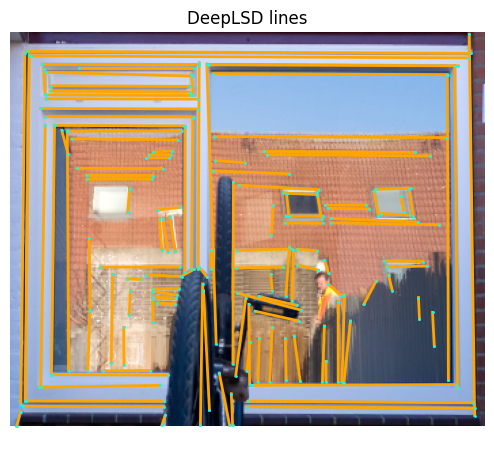

In [3]:
# Detect (and optionally refine) the lines
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

# Plot the predictions
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([pred_lines], indices=range(1))

In [4]:
# part_lines = pred_lines[0:5]

# # plot_images([img], ['DeepLSD lines'], cmaps='gray')
# # plot_lines([part_lines], indices=range(1))
# # print(part_lines)

# # p = (x, y) corner = (x, y)
# def distance_to_corner(p, corner):
#     x,y = 
#     return np.linalg.norm(p - corner)

# min_points = part_lines
# for p in part_lines:
#     if distance_to_corner(p, (0, 0)) < distance_to_corner(min_points, (0, 0)):
#         min_points = p

# print(min_points)

# print(part_lines.shape)
# print(pred_lines.shape)


# min_points = min_points[np.newaxis, :]
# print(min_points.shape)


# plot_images([img], ['DeepLSD lines'], cmaps='gray')
# plot_lines([min_points], line_colors='green', indices=range(1))


In [5]:
def get_closest_line(lines, point):
    dist = np.sqrt(np.sum((lines.reshape(-1,2) - point)**2, axis=1))
    dist_modified = np.where(dist == 0, np.inf, dist)
    closest = np.argmin(dist_modified)

    index = np.unravel_index(closest, lines.shape[:-1])
    return lines[index[0],:]

[[ 11.997291   13.636288 ]
 [339.00415    15.0285015]]
[[  7.537361 274.0062  ]
 [ 10.524162  14.994513]]
[[  8.996268 275.20828 ]
 [112.99837  275.5295  ]]
(3, 2, 2)


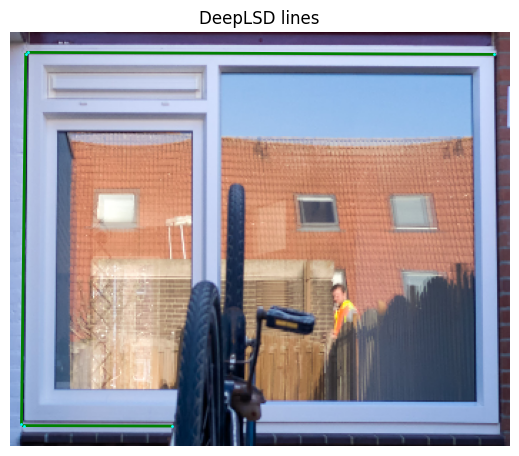

In [6]:
inputs = {'image': torch.tensor(gray_img, dtype=torch.float, device=device)[None, None] / 255.}
with torch.no_grad():
    out = net(inputs)
    pred_lines = out['lines'][0]

dist = np.sqrt(np.sum((pred_lines.reshape(-1,2) - np.array([0, 0]))**2, axis=1))
closest = np.argmin(dist)
index = np.unravel_index(closest, pred_lines.shape[:-1])

top_lef_corner = pred_lines[index[0],:]

print(top_lef_corner)

top_lef_corner = top_lef_corner[np.newaxis, :]
#print(top_lef_corner[0][0])
#pred_lines = np.delete(pred_lines, index[0], axis=0)
p2 = get_closest_line(pred_lines, top_lef_corner[0][0])
print(p2)

p3 = get_closest_line(pred_lines, p2[0])

print(p3)

top_lef_corner = np.concatenate((top_lef_corner, p2[np.newaxis, :]), axis=0)
top_lef_corner = np.concatenate((top_lef_corner, p3[np.newaxis, :]), axis=0)

print(top_lef_corner.shape)

plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([top_lef_corner], line_colors='green', indices=range(1))

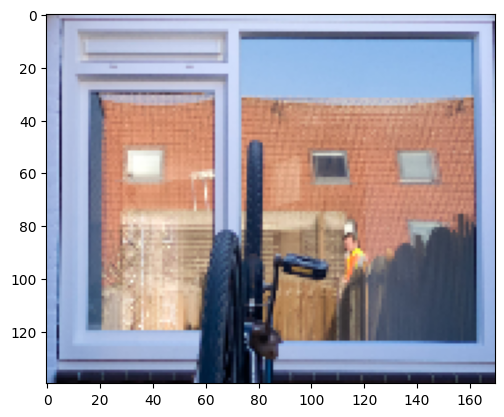

In [7]:
# create a cropped image of these coords
# [178.87998962402344, 161.0399932861328, 340.1600036621094, 297.8399963378906]
img = cv2.imread('../../images/1DJI0005.jpg')[:, :, ::-1]
img = cv2.resize(img, (640, 480))
# crop the image
img = img[160:300, 270:440]

# show the cropped image
plt.imshow(img)

In [8]:
# line_arr has only long lines
# first arg of thresholds to make sure lines are not too small, second arg to make sure lines are connected
def get_square(line_arr, corner_pt, thresholds = [8.11]):
    # get the distance from corners for each line
    dist = np.sqrt(np.sum((line_arr.reshape(-1,2) - corner_pt)**2, axis=1))
    # get the index of the closest line and second closest line
    partitioned_indices = np.argpartition(dist, 2)[:2]
    closest = partitioned_indices[0]
    second_closest = partitioned_indices[1]

    # get the actual lines using unravel index
    closest_line = np.unravel_index(closest, line_arr.shape[:-1])
    second_closest_line = np.unravel_index(second_closest, line_arr.shape[:-1])

    # get the actual lines
    closest_line = line_arr[closest_line[0],:]
    second_closest_line = line_arr[second_closest_line[0],:]

    square_lst = []
    # put both in a queue
    queue = [closest_line, second_closest_line]
    while len(queue):
        # get the first element
        line = queue.pop(0)
        square_lst.append(line)
        # delete the line from the array
        line_arr = np.delete(line_arr, np.where((line_arr == line).all(axis=1)), axis=0)
        # get the distance from line to line_arr
        dist = np.sqrt(np.sum((line_arr.reshape(-1,2) - line[1])**2, axis=1))

        # get the indices of the lines that are close to the line

        #indices = np.where(dist < thresholds[0])
        smallest_dist_index = np.argmin(dist)
        # check if the distance is small enough
        if dist[smallest_dist_index] < thresholds[0]:
            # get the line that is closest
            line_index = np.unravel_index(smallest_dist_index, line_arr.shape[:-1])
            line = line_arr[line_index[0],:]
            # put the line in the queue
            queue.append(line)
        
    return np.array(square_lst)



square_arr = get_square(pred_lines, np.array([0, 0]))



In [9]:
square_arr.shape

(4, 2, 2)

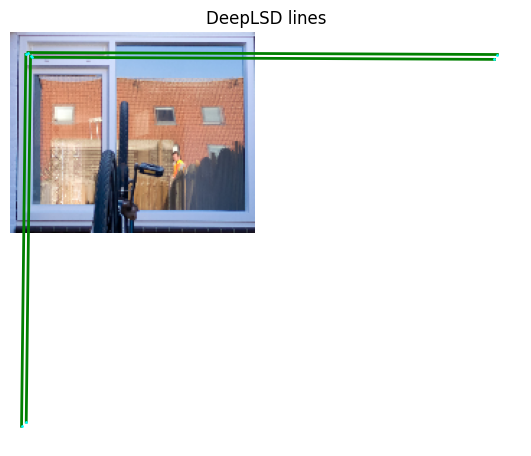

In [10]:
plot_images([img], ['DeepLSD lines'], cmaps='gray')
plot_lines([square_arr], line_colors='green', indices=range(1))